## Analyzing Easy Visa Application Status

### Objectives
----------
	To demonstrate creating an ML Pipeline to i) preprocess
	a dataset, ii) train a Machine Learning model, and iii) make
	predictions.

### Data:
-----
	The dataset contains incidents of visa applicatus status
	along with 12 explanatory variables. The data has 
    25480 instances.
    

Fields :
	Features:
       Target variable: case_status [denied or certified]
       Independent varibles: Related to employee and employer attributes
	

### Goal:
------
With the help of a classification model:
    1. Facilitate the process of visa approvals.
    2. Recommend a suitable profile for the applicants for whom the visa should be certified or denied based on the drivers that significantly influence the case status.

    
### Approach:
----------
	We will use Spark ML Pipelines, which help
	users piece together parts of a workflow such as
	feature processing and model training. We will also
	demonstrate model selection (a.k.a. hyperparameter
	tuning) using Cross Validation in order to fine-tune
	and improve our ML model.

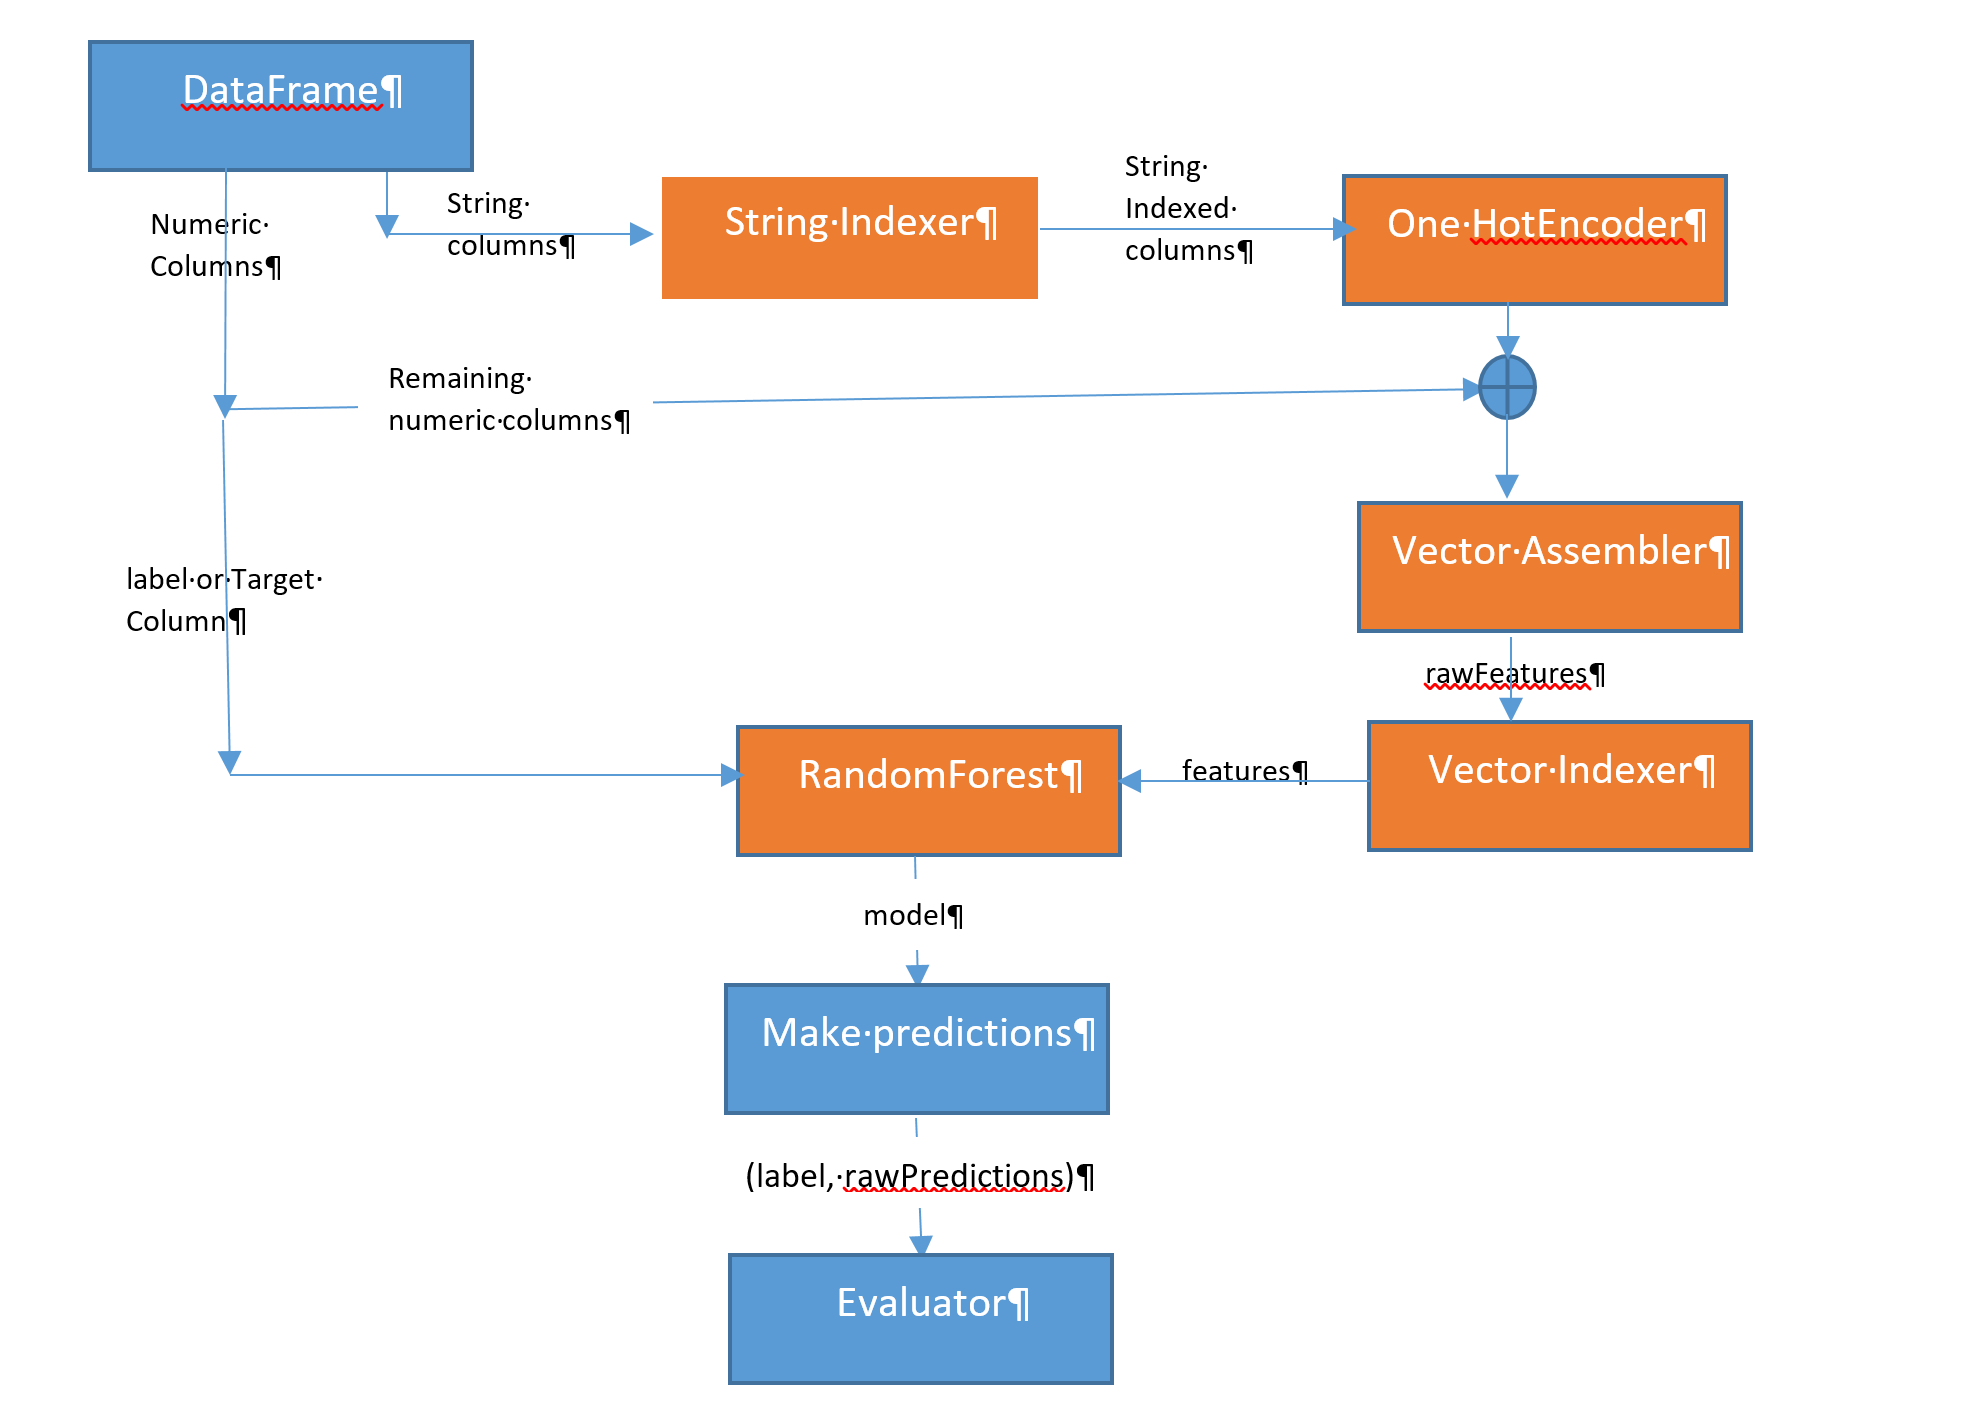

In [1]:
# 0.0 The following image displays data-processing pipeline
from IPython.display import Image
Image(filename='spark_ml_pipeline.png') 

In [2]:

"""
AA.
===

Start hadoop:

           ./allstart.sh
BB.           
===
Copy following four commands and paste them in the terminal


      cd ~
      hdfs dfs -put /home/ashok/Downloads/EasyVisa.csv  hdfs://localhost:9000/user/ashok/data_files
      hdfs dfs -ls hdfs://localhost:9000/user/ashok/data_files        
      cd ~


"""

'\nAA.\n===\n\nStart hadoop:\n\n           ./allstart.sh\nBB.           \n===\nCopy following four commands and paste them in the terminal\n\n\n      cd ~\n      hdfs dfs -put /home/ashok/Downloads/EasyVisa.csv  hdfs://localhost:9000/user/ashok/data_files\n      hdfs dfs -ls hdfs://localhost:9000/user/ashok/data_files        \n      cd ~\n\n\n'

In [3]:
# 1.0 Call libraries
# 1.0 Encode 'string' column to index-column. 
#     Indexing begins from 0.
from pyspark.ml.feature import StringIndexer, OneHotEncoder
# 1.1 OHE an indexed column after StringIndexing
#     and create one another column
#from pyspark.ml.feature import OneHotEncoderEstimator
# 1.2 Assemble numerical and OHE data in one column
from pyspark.ml.feature import VectorAssembler
# 1.3 Scale Vector-Assmbled data. Individual columns
#     will have to be scaled 'manually' using withColumn()
#     statement and writing your own scaling formula
from pyspark.ml.feature import StandardScaler
# 1.4 Vector Index one column assembled+scaled as above
from pyspark.ml.feature import VectorIndexer

# 1.5 Import ML estimator. It is a classification problem
from pyspark.ml.classification import RandomForestClassifier

# 1.6 Create a pipeline model for all stages
from pyspark.ml import Pipeline

# 1.7 Misc functions
# 1.7.1 Call an important group of sql functions
from pyspark.sql.functions import col,sum
# 1.7.2 Unlike in other languages, in spark
#       type-classes are to be separateky imported
#       They are not part of core classes or modules
from pyspark.sql.types import DoubleType

# 1.8 Binary classification results evaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# 1.9
import os, time

In [4]:
# 2. Increase the width of notebook 
#    to display all columns of data
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_3177/3837713901.py:3: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [5]:
# 2.1 Show multiple outputs of a single cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [6]:
# 3. Read, transform and understand the data
#      https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.csv
#    pyspark creates a spark-session variable: spark

df = spark.read.csv(
                   path = "hdfs://localhost:9000/user/ashok/data_files/EasyVisa.csv",   # path to hadoop
                   header = True,
                   inferSchema= True,           # Infer datatypes automatically
                   sep = ","                   # Can be any character (check \t)
                   )


### Quick Explore data

In [7]:
# 3.1 Data shape
df.count()           # 45429
cols = df.columns
len(cols)            # 54
print(cols)

25480

12

['case_id', 'continent', 'education_of_employee', 'has_job_experience', 'requires_job_training', 'no_of_employees', 'yr_of_estab', 'region_of_employment', 'prevailing_wage', 'unit_of_wage', 'full_time_position', 'case_status']


In [8]:
df.describe().show()

+-------+--------+-------------+---------------------+------------------+---------------------+------------------+------------------+--------------------+------------------+------------+------------------+-----------+
|summary| case_id|    continent|education_of_employee|has_job_experience|requires_job_training|   no_of_employees|       yr_of_estab|region_of_employment|   prevailing_wage|unit_of_wage|full_time_position|case_status|
+-------+--------+-------------+---------------------+------------------+---------------------+------------------+------------------+--------------------+------------------+------------+------------------+-----------+
|  count|   25480|        25480|                25480|             25480|                25480|             25480|             25480|               25480|             25480|       25480|             25480|      25480|
|   mean|    null|         null|                 null|              null|                 null| 5667.043210361067| 1979.40992935

In [9]:
df.columns

['case_id',
 'continent',
 'education_of_employee',
 'has_job_experience',
 'requires_job_training',
 'no_of_employees',
 'yr_of_estab',
 'region_of_employment',
 'prevailing_wage',
 'unit_of_wage',
 'full_time_position',
 'case_status']

23/09/29 14:35:18 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


<AxesSubplot:xlabel='continent'>

Text(0.5, 0, 'Continent')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Bar Plot of Continent and Education of Employee')

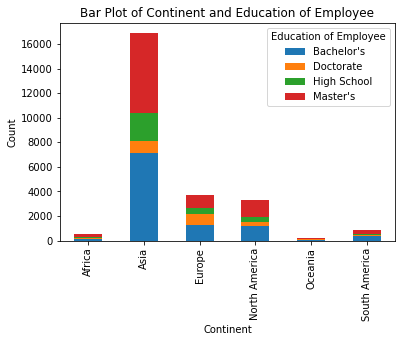

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import count

# Create a Spark session
spark = SparkSession.builder.appName("GroupByExample").getOrCreate()

# Assuming you have a DataFrame named 'df' with columns 'continent' and 'education_of_employee'

# Step 1: Group by 'continent' and 'education_of_employee'
grouped_df = df.groupBy('continent', 'education_of_employee')

# Step 2: Aggregate to count the occurrences
agg_df = grouped_df.agg(count('*').alias('count'))

# Step 3: Convert to Pandas DataFrame for plotting
pandas_df = agg_df.toPandas()

# Step 4: Create a bar plot
pivot_df = pandas_df.pivot(index='continent', columns='education_of_employee', values='count')
pivot_df.plot(kind='bar', stacked=True)

plt.xlabel('Continent')
plt.ylabel('Count')
plt.title('Bar Plot of Continent and Education of Employee')
plt.legend(title='Education of Employee')
plt.show()
plt.figure(figsize=(30, 30))  # Adjust the width and height as needed


<AxesSubplot:xlabel='continent'>

Text(0.5, 0, 'Continent')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Bar Plot of Continent wise Loan apllication status')

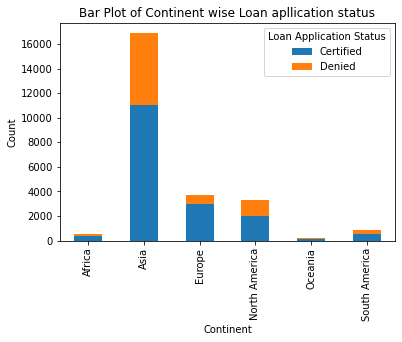

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import count

# Create a Spark session
spark = SparkSession.builder.appName("GroupByExample").getOrCreate()

# Assuming you have a DataFrame named 'df' with columns 'continent' and 'education_of_employee'

# Step 1: Group by 'continent' and 'education_of_employee'
grouped_df = df.groupBy('continent', 'case_status')

# Step 2: Aggregate to count the occurrences
agg_df = grouped_df.agg(count('*').alias('count'))

# Step 3: Convert to Pandas DataFrame for plotting
pandas_df = agg_df.toPandas()

# Step 4: Create a bar plot
pivot_df = pandas_df.pivot(index='continent', columns='case_status', values='count')
pivot_df.plot(kind='bar', stacked=True)

plt.xlabel('Continent')
plt.ylabel('Count')
plt.title('Bar Plot of Continent wise Loan apllication status')
plt.legend(title='Loan Application Status')
plt.show()
plt.figure(figsize=(30, 30))  # Adjust the width and height as needed


<AxesSubplot:xlabel='has_job_experience'>

Text(0.5, 0, 'Experience')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Bar Plot of Experiance wise Loan apllication status')

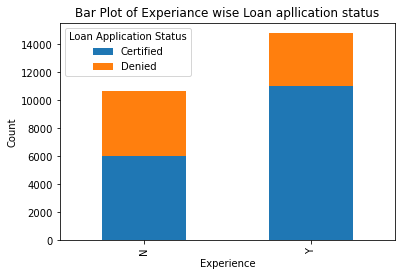

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import count

# Create a Spark session
spark = SparkSession.builder.appName("GroupByExample").getOrCreate()

# Assuming you have a DataFrame named 'df' with columns 'continent' and 'education_of_employee'

# Step 1: Group by 'continent' and 'education_of_employee'
grouped_df = df.groupBy('has_job_experience', 'case_status')

# Step 2: Aggregate to count the occurrences
agg_df = grouped_df.agg(count('*').alias('count'))

# Step 3: Convert to Pandas DataFrame for plotting
pandas_df = agg_df.toPandas()

# Step 4: Create a bar plot
pivot_df = pandas_df.pivot(index='has_job_experience', columns='case_status', values='count')
pivot_df.plot(kind='bar', stacked=True)

plt.xlabel('Experience')
plt.ylabel('Count')
plt.title('Bar Plot of Experiance wise Loan apllication status')
plt.legend(title='Loan Application Status')
plt.show()
plt.figure(figsize=(30, 30))  # Adjust the width and height as needed


23/09/29 14:35:20 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


<Figure size 576x432 with 0 Axes>

{'whiskers': [<matplotlib.lines.Line2D at 0x7fd029f4bf70>,
 'caps': [<matplotlib.lines.Line2D at 0x7fd029f60610>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fd029f4bca0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fd029f60af0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fd029f60dc0>],
 'means': []}

Text(0.5, 0, 'Prevailing Wage')

Text(0.5, 1.0, 'Box Plot of Prevailing Wage')

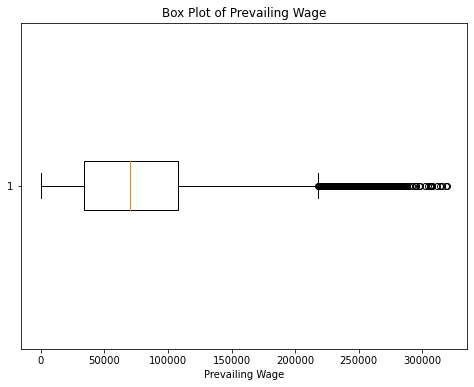

In [13]:
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
import pandas as pd

# Create a Spark session
spark = SparkSession.builder.appName("BoxPlotExample").getOrCreate()

# Assuming you have a DataFrame named 'df' with a column 'prevailing_wage'

# Step 1: Convert the 'prevailing_wage' column to a Pandas Series
prevailing_wage_series = df.select('prevailing_wage').rdd.flatMap(lambda x: x).collect()

# Step 2: Create a Pandas DataFrame from the series
pandas_df = pd.DataFrame({'prevailing_wage': prevailing_wage_series})

# Step 3: Create a box plot using Matplotlib
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed

# Create the box plot
plt.boxplot(pandas_df['prevailing_wage'], vert=False)

# Customize labels and title
plt.xlabel('Prevailing Wage')
plt.title('Box Plot of Prevailing Wage')

# Show the plot
plt.show()


In [14]:
# 3.2 We also cache the data so that
#     we only read it from disk once.

df.cache()

DataFrame[case_id: string, continent: string, education_of_employee: string, has_job_experience: string, requires_job_training: string, no_of_employees: int, yr_of_estab: int, region_of_employment: string, prevailing_wage: double, unit_of_wage: string, full_time_position: string, case_status: string]

In [15]:
# 3.3 Show database in parts.
#     Last column is target.
#     Few columns are strings
#     Most columns appear to be integers

df.select(cols[:5]).show(3)
df.select(cols[5:10]).show(3)
df.select(cols[10:]).show(3)

+-------+---------+---------------------+------------------+---------------------+
|case_id|continent|education_of_employee|has_job_experience|requires_job_training|
+-------+---------+---------------------+------------------+---------------------+
| EZYV01|     Asia|          High School|                 N|                    N|
| EZYV02|     Asia|             Master's|                 Y|                    N|
| EZYV03|     Asia|           Bachelor's|                 N|                    Y|
+-------+---------+---------------------+------------------+---------------------+
only showing top 3 rows

+---------------+-----------+--------------------+---------------+------------+
|no_of_employees|yr_of_estab|region_of_employment|prevailing_wage|unit_of_wage|
+---------------+-----------+--------------------+---------------+------------+
|          14513|       2007|                West|       592.2029|        Hour|
|           2412|       2002|           Northeast|       83425.65|        

In [16]:
# 3.4 Check missing values:
#     https://stackoverflow.com/questions/44413132/count-the-number-of-missing-values-in-a-dataframe-spark
#     Try to understand this one line statement. It is educative.
#     Note that the statement is 'tuple comprehension' rather than usual list-comprehension.
#     Try replacing alias(c) with alias('missing')

df.select(*(sum(df[c].isNull().cast("int")).alias(c) for c in cols[:5])).show()    
df.select(*(sum(df[c].isNull().cast("int")).alias(c) for c in cols[5:10])).show()
df.select(*(sum(df[c].isNull().cast("int")).alias(c) for c in cols[10:])).show()

+-------+---------+---------------------+------------------+---------------------+
|case_id|continent|education_of_employee|has_job_experience|requires_job_training|
+-------+---------+---------------------+------------------+---------------------+
|      0|        0|                    0|                 0|                    0|
+-------+---------+---------------------+------------------+---------------------+

+---------------+-----------+--------------------+---------------+------------+
|no_of_employees|yr_of_estab|region_of_employment|prevailing_wage|unit_of_wage|
+---------------+-----------+--------------------+---------------+------------+
|              0|          0|                   0|              0|           0|
+---------------+-----------+--------------------+---------------+------------+

+------------------+-----------+
|full_time_position|case_status|
+------------------+-----------+
|                 0|          0|
+------------------+-----------+



In [17]:
# 3.5 Rename target column 'case_status' to 'label'
#     This target name is used, by default, by ML algorithms 

df1 = df.withColumnRenamed('case_status', 'label')
print(df1.columns)

['case_id', 'continent', 'education_of_employee', 'has_job_experience', 'requires_job_training', 'no_of_employees', 'yr_of_estab', 'region_of_employment', 'prevailing_wage', 'unit_of_wage', 'full_time_position', 'label']


In [18]:
from pyspark.sql.functions import when
df1 = df1.withColumn("label", when(df1["label"] == "Certified", 1).otherwise(0))

df1.show()

+-------+-------------+---------------------+------------------+---------------------+---------------+-----------+--------------------+---------------+------------+------------------+-----+
|case_id|    continent|education_of_employee|has_job_experience|requires_job_training|no_of_employees|yr_of_estab|region_of_employment|prevailing_wage|unit_of_wage|full_time_position|label|
+-------+-------------+---------------------+------------------+---------------------+---------------+-----------+--------------------+---------------+------------+------------------+-----+
| EZYV01|         Asia|          High School|                 N|                    N|          14513|       2007|                West|       592.2029|        Hour|                 Y|    0|
| EZYV02|         Asia|             Master's|                 Y|                    N|           2412|       2002|           Northeast|       83425.65|        Year|                 Y|    1|
| EZYV03|         Asia|           Bachelor's|     

In [19]:
from pyspark.sql.functions import countDistinct
unique_counts = [countDistinct(col).alias(col) for col in df1.columns]
unique_counts_df = df1.agg(*unique_counts)
unique_counts_df.show()

+-------+---------+---------------------+------------------+---------------------+---------------+-----------+--------------------+---------------+------------+------------------+-----+
|case_id|continent|education_of_employee|has_job_experience|requires_job_training|no_of_employees|yr_of_estab|region_of_employment|prevailing_wage|unit_of_wage|full_time_position|label|
+-------+---------+---------------------+------------------+---------------------+---------------+-----------+--------------------+---------------+------------+------------------+-----+
|  25480|        6|                    4|                 2|                    2|           7105|        199|                   5|          25454|           4|                 2|    2|
+-------+---------+---------------------+------------------+---------------------+---------------+-----------+--------------------+---------------+------------+------------------+-----+



In [20]:
df1.dtypes

[('case_id', 'string'),
 ('continent', 'string'),
 ('education_of_employee', 'string'),
 ('has_job_experience', 'string'),
 ('requires_job_training', 'string'),
 ('no_of_employees', 'int'),
 ('yr_of_estab', 'int'),
 ('region_of_employment', 'string'),
 ('prevailing_wage', 'double'),
 ('unit_of_wage', 'string'),
 ('full_time_position', 'string'),
 ('label', 'int')]

In [76]:
df1.show(10)

+-------+-------------+---------------------+------------------+---------------------+---------------+-----------+--------------------+---------------+------------+------------------+-----+
|case_id|    continent|education_of_employee|has_job_experience|requires_job_training|no_of_employees|yr_of_estab|region_of_employment|prevailing_wage|unit_of_wage|full_time_position|label|
+-------+-------------+---------------------+------------------+---------------------+---------------+-----------+--------------------+---------------+------------+------------------+-----+
| EZYV01|         Asia|          High School|                 N|                    N|        14513.0|     2007.0|                West|       592.2029|        Hour|                 Y|  0.0|
| EZYV02|         Asia|             Master's|                 Y|                    N|         2412.0|     2002.0|           Northeast|       83425.65|        Year|                 Y|  1.0|
| EZYV03|         Asia|           Bachelor's|     

In [77]:
df2 = df1.toPandas()
df2

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,label
0,EZYV01,Asia,High School,N,N,14513.0,2007.0,West,592.2029,Hour,Y,0.0
1,EZYV02,Asia,Master's,Y,N,2412.0,2002.0,Northeast,83425.6500,Year,Y,1.0
2,EZYV03,Asia,Bachelor's,N,Y,44444.0,2008.0,West,122996.8600,Year,Y,0.0
3,EZYV04,Asia,Bachelor's,N,N,98.0,1897.0,West,83434.0300,Year,Y,0.0
4,EZYV05,Africa,Master's,Y,N,1082.0,2005.0,South,149907.3900,Year,Y,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
25475,EZYV25476,Asia,Bachelor's,Y,Y,2601.0,2008.0,South,77092.5700,Year,Y,1.0
25476,EZYV25477,Asia,High School,Y,N,3274.0,2006.0,Northeast,279174.7900,Year,Y,1.0
25477,EZYV25478,Asia,Master's,Y,N,1121.0,1910.0,South,146298.8500,Year,N,1.0
25478,EZYV25479,Asia,Master's,Y,Y,1918.0,1887.0,West,86154.7700,Year,Y,1.0


In [21]:
# 3.6 Show database structure.
#     Two types: 'int' and 'string'

df1type = df1.dtypes
print(df1type)

[('case_id', 'string'), ('continent', 'string'), ('education_of_employee', 'string'), ('has_job_experience', 'string'), ('requires_job_training', 'string'), ('no_of_employees', 'int'), ('yr_of_estab', 'int'), ('region_of_employment', 'string'), ('prevailing_wage', 'double'), ('unit_of_wage', 'string'), ('full_time_position', 'string'), ('label', 'int')]


In [22]:
# 4.1 Get a list of 'int' cols:

int_cols =   [ i[0] for i in df1.dtypes if i[1] == 'int' ] 
print(int_cols)

['no_of_employees', 'yr_of_estab', 'label']


In [23]:
# 4.2 Cast 'int' columns to 'double'
#     Needed by VectorIndexer.
#     Also it is a safe step

for colm in int_cols:
    df1 = df1.withColumn(colm, df1[colm].cast(DoubleType()))

print(df1.dtypes)

[('case_id', 'string'), ('continent', 'string'), ('education_of_employee', 'string'), ('has_job_experience', 'string'), ('requires_job_training', 'string'), ('no_of_employees', 'double'), ('yr_of_estab', 'double'), ('region_of_employment', 'string'), ('prevailing_wage', 'double'), ('unit_of_wage', 'string'), ('full_time_position', 'string'), ('label', 'double')]


############# Creating transformation objects  ######################
1.             StringIndexer
    - Inputs & outputs are Column names
-        OneHotEncoderEstimator
    - Inputs & outputs are Column names
-             VectorAssembler
    - Inputs & outputs: Column names
-             Scaler
    - Inputs & outputs are Column names
-             VectorIndexer
    - Inputs & outputs are Column names
-             RandomForest Estimator
    - Inputs: Column name; Output is model

In [24]:
# 4.3 Get list of String columns and for each, 
#     column create a separate StrinIndexer object
#     to fit and transform that column.
#     So we will have as many Stringindexed objects as there are 
#     'string' type columns

cat_columns = [ c[0] for c in df1.dtypes if c[1] == "string"]

# 4.4 Create StringIndexer object. Two sample output 
#     column names are: 'stringindexed_infBreastfeed' 'stringindexed_infMenin'

stringindexer_stages = [ StringIndexer(inputCol=c, outputCol='stringindexed_' + c, handleInvalid="keep") for c in cat_columns]
stringindexer_stages

[StringIndexer_e726b77c382f,
 StringIndexer_48354399567c,
 StringIndexer_19805026d13c,
 StringIndexer_28ffff976853,
 StringIndexer_67cc1ac35f28,
 StringIndexer_b03ec97d0005,
 StringIndexer_11187d66f55a,
 StringIndexer_6e408950185a]

In [25]:
# 4.5 Create OneHotEncoderEstimator object to transform Stringdexed columns
#     to OneHotEncoded form

in_cols = ['stringindexed_' + c for c in cat_columns]
ohe_cols = ['onehotencoded_' + c  for c in cat_columns]
onehotencoder_stages = [OneHotEncoder(inputCols=in_cols, outputCols=ohe_cols)]

In [26]:
# 5 Which columns are now explanatory variables? 
#     Type: double and OHE Columns

double_cols =   [  i[0] for i in df1.dtypes if i[1] == 'double' ] 

# 5.1 Remove 'target' column from this list:

double_cols.remove('label')   # earlier name 'infalive'

# 5.2 Create a combined list of double + ohe_cols

featuresCols = double_cols + ohe_cols
print(featuresCols)
len(featuresCols)       # 53

['no_of_employees', 'yr_of_estab', 'prevailing_wage', 'onehotencoded_case_id', 'onehotencoded_continent', 'onehotencoded_education_of_employee', 'onehotencoded_has_job_experience', 'onehotencoded_requires_job_training', 'onehotencoded_region_of_employment', 'onehotencoded_unit_of_wage', 'onehotencoded_full_time_position']


11

In [27]:
# 6   Create an instance of VectorAssembler class.
#          This object will be used to assemble all featureCols
#          (a list of columns) into one column with name
#           'rawFeatures'

vectorassembler = VectorAssembler(
                                  inputCols=featuresCols,
                                  outputCol="rawFeatures"
                                 )

In [28]:
# 6.1 Create an object to scale vectorassembled data
#     All the data is of type 'double'.
#     StandardScaler will only scale columns of type 'vector'
scaler = StandardScaler(inputCol="rawFeatures",
                        outputCol="scaledFeatures",
                        withStd=True,
                        withMean=True
                       )

In [29]:
# 7  Create an object to perform Vector Indexing 
#    that is automatically discover which numerical columns 
#    are categorical columns
#    Instantiate the object first
vectorindexer = VectorIndexer(inputCol="scaledFeatures",
                              outputCol="features",
                              maxCategories=5       # Reindex, if no of distinct values less than 5
                              )

In [30]:
# 8   Instantiate the classifier object
#     Takes the "features" column and learns to predict "label"
#     RandomForestClassifier(featuresCol='features',labelCol='label', predictionCol='prediction',
#                            probabilityCol='probability', rawPredictionCol='rawPrediction',
#                            maxDepth=5, maxBins=32, minInstancesPerNode=1, minInfoGain=0.0,
#                            maxMemoryInMB=256, cacheNodeIds=False, checkpointInterval=10,
#                            impurity='gini', numTrees=20, featureSubsetStrategy='auto',
#                            seed=None, subsamplingRate=1.0)

rf = RandomForestClassifier(
                            labelCol="label",         # This is default name
                            featuresCol="features",   # This is ALSO default name
                            numTrees=100
                            )


In [31]:
############# Data splitting and modeling ######################

In [32]:
# 9. Split the dataset randomly into 70% for
#    training and 30% for testing.
train, test = df1.randomSplit([0.7, 0.3])

# 8.1
print(train.count()/df1.count())
print(test.count()/df1.count())

0.6979984301412873
0.30200156985871274


In [33]:
# 9.2 Create pipeline model
pipeline = Pipeline(stages=[                       \
                            *stringindexer_stages, \
                            *onehotencoder_stages, \
                            vectorassembler,       \
                            scaler,                \
                            vectorindexer,         \
                            rf                     \
                           ]                       \
                   )

In [34]:
# 10. Run the pipeline. This will run complete pipe
#     including transform() methods of vectorassembler & vectorindexer
#     but transform() method of cv is not run. For cv,
#     it is just modeling and fitting; no transformation.
#    CONSUMES LOTS OF MEMORY. THINGS MAY SLOW DOWN
#    OR CONNECTIONS MAY BREAK

start = time.time()
pipelineModel = pipeline.fit(train)
end = time.time()
(end - start)/60           # Takes 1.98 minutes


23/09/29 14:35:30 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/09/29 14:35:31 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/09/29 14:35:31 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


23/09/29 14:35:45 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


23/09/29 14:35:46 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


23/09/29 14:35:57 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


23/09/29 14:36:11 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


23/09/29 14:36:16 WARN MemoryStore: Not enough space to cache rdd_265_0 in memory! (computed 347.7 MiB so far)
23/09/29 14:36:16 WARN BlockManager: Persisting block rdd_265_0 to disk instead.
23/09/29 14:36:27 WARN MemoryStore: Not enough space to cache rdd_265_0 in memory! (computed 347.7 MiB so far)


23/09/29 14:36:30 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


23/09/29 14:36:31 WARN MemoryStore: Not enough space to cache rdd_265_0 in memory! (computed 347.7 MiB so far)


23/09/29 14:36:34 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


23/09/29 14:36:35 WARN MemoryStore: Not enough space to cache rdd_265_0 in memory! (computed 347.7 MiB so far)


23/09/29 14:36:39 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


23/09/29 14:36:39 WARN MemoryStore: Not enough space to cache rdd_265_0 in memory! (computed 347.7 MiB so far)


23/09/29 14:36:42 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


23/09/29 14:36:43 WARN MemoryStore: Not enough space to cache rdd_265_0 in memory! (computed 347.7 MiB so far)


1.364040768146515

############# Predictions & evaluation  ######################

In [35]:

# 10.1 Make predictions on test data.
#      Note it is NOT pipelineModel.predict()

predictions = pipelineModel.transform(test)
type(predictions)               # Spark Dataframe

# 10.2 See the last five columns
print(predictions.columns)

pyspark.sql.dataframe.DataFrame

['case_id', 'continent', 'education_of_employee', 'has_job_experience', 'requires_job_training', 'no_of_employees', 'yr_of_estab', 'region_of_employment', 'prevailing_wage', 'unit_of_wage', 'full_time_position', 'label', 'stringindexed_case_id', 'stringindexed_continent', 'stringindexed_education_of_employee', 'stringindexed_has_job_experience', 'stringindexed_requires_job_training', 'stringindexed_region_of_employment', 'stringindexed_unit_of_wage', 'stringindexed_full_time_position', 'onehotencoded_case_id', 'onehotencoded_continent', 'onehotencoded_education_of_employee', 'onehotencoded_has_job_experience', 'onehotencoded_requires_job_training', 'onehotencoded_region_of_employment', 'onehotencoded_unit_of_wage', 'onehotencoded_full_time_position', 'rawFeatures', 'scaledFeatures', 'features', 'rawPrediction', 'probability', 'prediction']


In [82]:
pipelineModel.transform(df1)

DataFrame[case_id: string, continent: string, education_of_employee: string, has_job_experience: string, requires_job_training: string, no_of_employees: double, yr_of_estab: double, region_of_employment: string, prevailing_wage: double, unit_of_wage: string, full_time_position: string, label: double, stringindexed_case_id: double, stringindexed_continent: double, stringindexed_education_of_employee: double, stringindexed_has_job_experience: double, stringindexed_requires_job_training: double, stringindexed_region_of_employment: double, stringindexed_unit_of_wage: double, stringindexed_full_time_position: double, onehotencoded_case_id: vector, onehotencoded_continent: vector, onehotencoded_education_of_employee: vector, onehotencoded_has_job_experience: vector, onehotencoded_requires_job_training: vector, onehotencoded_region_of_employment: vector, onehotencoded_unit_of_wage: vector, onehotencoded_full_time_position: vector, rawFeatures: vector, scaledFeatures: vector, features: vector,

df3 = df1.toPandas()
df3

In [83]:
df3 = df1.toPandas()
df3

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,label
0,EZYV01,Asia,High School,N,N,14513.0,2007.0,West,592.2029,Hour,Y,0.0
1,EZYV02,Asia,Master's,Y,N,2412.0,2002.0,Northeast,83425.6500,Year,Y,1.0
2,EZYV03,Asia,Bachelor's,N,Y,44444.0,2008.0,West,122996.8600,Year,Y,0.0
3,EZYV04,Asia,Bachelor's,N,N,98.0,1897.0,West,83434.0300,Year,Y,0.0
4,EZYV05,Africa,Master's,Y,N,1082.0,2005.0,South,149907.3900,Year,Y,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
25475,EZYV25476,Asia,Bachelor's,Y,Y,2601.0,2008.0,South,77092.5700,Year,Y,1.0
25476,EZYV25477,Asia,High School,Y,N,3274.0,2006.0,Northeast,279174.7900,Year,Y,1.0
25477,EZYV25478,Asia,Master's,Y,N,1121.0,1910.0,South,146298.8500,Year,N,1.0
25478,EZYV25479,Asia,Master's,Y,Y,1918.0,1887.0,West,86154.7700,Year,Y,1.0


In [36]:
# 10.3 Check the types of last 
#      few columns that you have created
#      Some are 'vector' types
print(predictions.dtypes)

[('case_id', 'string'), ('continent', 'string'), ('education_of_employee', 'string'), ('has_job_experience', 'string'), ('requires_job_training', 'string'), ('no_of_employees', 'double'), ('yr_of_estab', 'double'), ('region_of_employment', 'string'), ('prevailing_wage', 'double'), ('unit_of_wage', 'string'), ('full_time_position', 'string'), ('label', 'double'), ('stringindexed_case_id', 'double'), ('stringindexed_continent', 'double'), ('stringindexed_education_of_employee', 'double'), ('stringindexed_has_job_experience', 'double'), ('stringindexed_requires_job_training', 'double'), ('stringindexed_region_of_employment', 'double'), ('stringindexed_unit_of_wage', 'double'), ('stringindexed_full_time_position', 'double'), ('onehotencoded_case_id', 'vector'), ('onehotencoded_continent', 'vector'), ('onehotencoded_education_of_employee', 'vector'), ('onehotencoded_has_job_experience', 'vector'), ('onehotencoded_requires_job_training', 'vector'), ('onehotencoded_region_of_employment', 'vec

In [37]:
# 10.4 Show all columns including predicted column
#      featuresCols: See para 6.2 above
#      What is meant by rawPerdiction. Please see this link:
#      https://stackoverflow.com/a/37909854

predictions.select("label", "prediction", 'rawPrediction', 'probability').show(4, False)

23/09/29 14:36:48 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
+-----+----------+-------------------------------------+----------------------------------------+
|label|prediction|rawPrediction                        |probability                             |
+-----+----------+-------------------------------------+----------------------------------------+
|0.0  |1.0       |[39.11905900663845,60.88094099336151]|[0.3911905900663846,0.6088094099336153] |
|1.0  |1.0       |[31.56413099501887,68.43586900498116]|[0.31564130995018863,0.6843586900498114]|
|0.0  |1.0       |[34.42002213585416,65.57997786414583]|[0.3442002213585416,0.6557997786414583] |
|1.0  |1.0       |[34.27515703402247,65.72484296597752]|[0.34275157034022474,0.6572484296597753]|
+-----+----------+-------------------------------------+----------------------------------------+
only showing top 4 rows



In [38]:
# 10.5 Evaluate results
# Ref: http://spark.apache.org/docs/2.2.0/api/python/pyspark.ml.html#pyspark.ml.evaluation.RegressionEvaluator
# Create evaluator object.  

evaluator = BinaryClassificationEvaluator(
                                          rawPredictionCol='rawPrediction', # This is default name
                                          labelCol='label',                 # This is defalut name
                                          metricName='areaUnderROC'         # This is default metirc
                                          )

areaUnderROC = evaluator.evaluate(predictions)
areaUnderROC

23/09/29 14:36:49 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


0.7559406765869174

23/09/29 14:36:57 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


<Figure size 576x576 with 0 Axes>

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver Operating Characteristic (ROC) Curve')

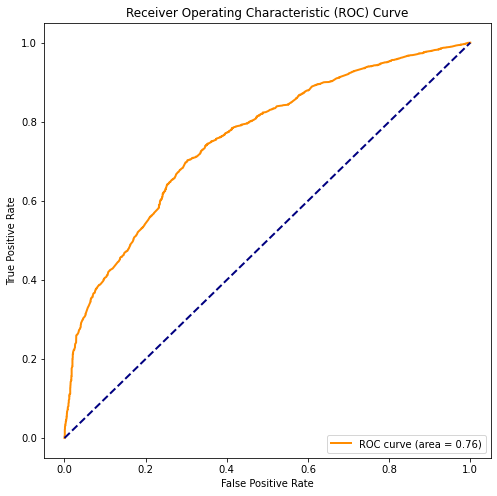

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Assuming 'predictions' is your PySpark DataFrame containing predictions
# and 'label' is the true label column, and 'rawPrediction' is the raw prediction column

# Convert the PySpark DataFrame to a Pandas DataFrame
predictions_pd = predictions.select('label', 'rawPrediction').toPandas()

# Get the true labels and raw predictions as NumPy arrays
y_true = predictions_pd['label'].values
y_scores = predictions_pd['rawPrediction'].apply(lambda x: x[1]).values

# Compute ROC curve and area under the curve
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [79]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.sql.functions import col
import pandas as pd

# Create a Spark session
spark = SparkSession.builder.appName("RandomForestFeatureImportance").getOrCreate()

# Assuming you have a DataFrame X_train with your features and a target column
# Replace 'features' and 'label' with the actual column names in your DataFrame

feature_columns = [df1[['continent', 'education_of_employee', 'has_job_experience', 'requires_job_training', 'no_of_employees', 'yr_of_estab', 'region_of_employment', 'prevailing_wage', 'unit_of_wage', 'full_time_position']]]

# Create a VectorAssembler to assemble your feature columns
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Transform the train set using the VectorAssembler
train_data = vector_assembler.transform(train)

# Train the Random Forest classifier
rf = RandomForestClassifier(numTrees=100, featuresCol="features", labelCol="label")
rf_model = rf.fit(train_data)

# Make predictions on the test set
test_data = vector_assembler.transform(test)
predictions = rf_model.transform(test_data)

# Evaluate the model if needed (e.g., using BinaryClassificationEvaluator)
evaluator = BinaryClassificationEvaluator(labelCol="label")
auc = evaluator.evaluate(predictions)
print("AUC:", auc)


TypeError: Invalid param value given for param "inputCols". Could not convert [DataFrame[continent: string, education_of_employee: string, has_job_experience: string, requires_job_training: string, no_of_employees: double, yr_of_estab: double, region_of_employment: string, prevailing_wage: double, unit_of_wage: string, full_time_position: string]] to list of strings

In [40]:
################### I am done ###################

In [41]:
################### Advanced for debugging ###################

In [42]:
## ADVANCED FOR DEBUGGING
# 11.  Should you want an intermediate pipeline to debug the code
#      or to see what all is happening here is the quick code
pipeline1 = Pipeline(stages=[*stringindexer_stages,*onehotencoder_stages,vectorassembler, scaler, vectorindexer])
pipelineModelx = pipeline1.fit(df)  # Learn train
tr = pipelineModelx.transform(df)   # Transform train through all stages
cls = tr.columns             # List of columns in this dataframe  
numb = len(tr.columns)
tr.select(cls[(numb-4): ]).show(3)  # See Ist four columns

23/09/29 14:37:05 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/09/29 14:37:05 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/09/29 14:37:06 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


23/09/29 14:37:36 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
+--------------------------------+--------------------+--------------------+--------------------+
|onehotencoded_full_time_position|         rawFeatures|      scaledFeatures|            features|
+--------------------------------+--------------------+--------------------+--------------------+
|                   (2,[0],[1.0])|(25508,[0,1,2,3,2...|[0.38665898685644...|[0.38665898685644...|
|                   (2,[0],[1.0])|(25508,[0,1,2,4,2...|[-0.1422787539914...|[-0.1422787539914...|
|                   (2,[0],[1.0])|(25508,[0,1,2,5,2...|[1.69495049345250...|[1.69495049345250...|
+--------------------------------+--------------------+--------------------+--------------------+
only showing top 3 rows



In [43]:
# 11.1 Further, should you want to access
#      some attribute of an intermediate 
#      stage-model, here is the way:

# 11.1.1 What are pipeline model stages:
pipelineModelx.stages

# 11.1.2 How to access VectorIndexer model:
pipelineModelx.stages[-1].categoryMaps

# 11.1.3 So VectorIndexer transformed how many columns:
len(pipelineModelx.stages[-1].categoryMaps)


[StringIndexerModel: uid=StringIndexer_e726b77c382f, handleInvalid=keep,
 StringIndexerModel: uid=StringIndexer_48354399567c, handleInvalid=keep,
 StringIndexerModel: uid=StringIndexer_19805026d13c, handleInvalid=keep,
 StringIndexerModel: uid=StringIndexer_28ffff976853, handleInvalid=keep,
 StringIndexerModel: uid=StringIndexer_67cc1ac35f28, handleInvalid=keep,
 StringIndexerModel: uid=StringIndexer_b03ec97d0005, handleInvalid=keep,
 StringIndexerModel: uid=StringIndexer_11187d66f55a, handleInvalid=keep,
 StringIndexerModel: uid=StringIndexer_6e408950185a, handleInvalid=keep,
 OneHotEncoderModel: uid=OneHotEncoder_7a6b19a7dd89, dropLast=true, handleInvalid=error, numInputCols=8, numOutputCols=8,
 VectorAssembler_1e63cfc98bc3,
 StandardScalerModel: uid=StandardScaler_aff6631709b3, numFeatures=25508, withMean=true, withStd=true,
 VectorIndexerModel: uid=VectorIndexer_90a79306c765, numFeatures=25508, handleInvalid=error]

{14221: {-0.006264700137907352: 0, 159.61829481374141: 1}, 2163: {-0.006264700137907352: 0, 159.61829481374141: 1}, 8607: {-0.006264700137907352: 0, 159.61829481374141: 1}, 645: {-0.006264700137907352: 0, 159.61829481374141: 1}, 13950: {-0.006264700137907352: 0, 159.61829481374141: 1}, 20873: {-0.006264700137907352: 0, 159.61829481374141: 1}, 23162: {-0.006264700137907352: 0, 159.61829481374141: 1}, 16466: {-0.006264700137907352: 0, 159.61829481374141: 1}, 19887: {-0.006264700137907352: 0, 159.61829481374141: 1}, 18180: {-0.006264700137907352: 0, 159.61829481374141: 1}, 16383: {-0.006264700137907352: 0, 159.61829481374141: 1}, 892: {-0.006264700137907352: 0, 159.61829481374141: 1}, 69: {-0.006264700137907352: 0, 159.61829481374141: 1}, 10822: {-0.006264700137907352: 0, 159.61829481374141: 1}, 16216: {-0.006264700137907352: 0, 159.61829481374141: 1}, 23563: {-0.006264700137907352: 0, 159.61829481374141: 1}, 23764: {-0.006264700137907352: 0, 159.61829481374141: 1}, 15874: {-0.00626470013

25505

In [44]:
pip install sparkxgb

  Using cached pyspark-3.1.1-py2.py3-none-any.whl
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.3.0
    Can't uninstall 'pyspark'. No files were found to uninstall.
Note: you may need to restart the kernel to use updated packages.


In [45]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from sparkxgb import XGBoostClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Create a Spark session
spark = SparkSession.builder.appName("XGClassifierExample").getOrCreate()

# Sample DataFrame with features and labels
#data = [(0, [0.1, 0.2, 0.3]), (1, [0.4, 0.5, 0.6]), (0, [0.7, 0.8, 0.9]), (1, [0.2, 0.3, 0.4])]
#df = spark.createDataFrame(df1, ["label", "features"])

# Step 2: Use VectorAssembler to create a feature vector

vectorassembler = VectorAssembler(
                                  inputCols=featuresCols,
                                  outputCol="rawFeatures"
                                 )

scaler = StandardScaler(inputCol="rawFeatures",
                        outputCol="scaledFeatures",
                        withStd=True,
                        withMean=True
                       )
vectorindexer = VectorIndexer(inputCol="scaledFeatures",
                              outputCol="features",
                              maxCategories=5       # Reindex, if no of distinct values less than 5
                              )

# Step 4: Create an instance of XGClassifier
xgb = XGBoostClassifier(
    labelCol="label",          # This is the default name
    featuresCol="features_vector",
    numRound=100                # Number of boosting rounds (equivalent to numTrees in RandomForest)
)
# 9.2 Create pipeline model
pipeline = Pipeline(stages=[                       \
                            *stringindexer_stages, \
                            *onehotencoder_stages, \
                            vector_assembler,       \
                            scaler,                \
                            vectorindexer,         \
                            xgb                    \
                           ]                       \
                   )

# Step 3: Split the data into training and testing sets
(training_data, testing_data) = df1.randomSplit([0.8, 0.2], seed=123)

# Step 5: Fit the classifier on the training data
xgb_model = xgb.fit(training_data)

# Step 6: Make predictions on the testing data
predictions = xgb_model.transform(testing_data)

# Step 7: Evaluate the classifier's performance using BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="label")
areaUnderROC = evaluator.evaluate(predictions)

print(f"Area Under ROC: {areaUnderROC}")



23/09/29 14:44:39 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


TypeError: 'JavaPackage' object is not callable

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from sparkxgb import XGBoostClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline

# Create a Spark session
spark = SparkSession.builder.appName("XGClassifierExample").getOrCreate()

# Sample DataFrame with features and labels
# data = [(0, [0.1, 0.2, 0.3]), (1, [0.4, 0.5, 0.6]), (0, [0.7, 0.8, 0.9]), (1, [0.2, 0.3, 0.4])]
# df = spark.createDataFrame(df1, ["label", "features"])

# Assuming you have already obtained the 'df' DataFrame with 'label' and 'features' columns

# Step 5: Create an instance of XGClassifier
xgb = XGBoostClassifier(
    labelCol="label",
    featuresCol="features",
    numRound=100  # Number of boosting rounds (equivalent to numTrees in RandomForest)
)

# Step 6: Create a pipeline
pipeline = Pipeline(stages=[vectorassembler, xgb])

# Step 7: Split the data into training and testing sets
(training_data, testing_data) = df.randomSplit([0.8, 0.2], seed=123)

# Step 8: Fit the model on the training data
xgb_model = pipeline.fit(training_data)

# Step 9: Make predictions on the testing data
predictions = xgb_model.transform(testing_data)

# Step 10: Evaluate the classifier's performance using BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="label")
areaUnderROC = evaluator.evaluate(predictions)

print(f"Area Under ROC: {areaUnderROC}")


23/09/29 16:09:12 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1022955 ms exceeds timeout 120000 ms
23/09/29 16:09:12 WARN SparkContext: Killing executors is not supported by current scheduler.


################### I am done ###################